In [150]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import seaborn as sns 
import matplotlib.pyplot as plt 

np.random.seed(42)

NUM_USERS = 2000
MAX_SESSIONS = 15

events = ["login", "view", "click", "add_to_cart", "purchase", "logout"]
devices = ["desktop","ios","android"]
countries = ["India", "US", "UK", "Canada"]

rows = []
start_date = datetime(2024, 1, 1)

for user_id in range(1, NUM_USERS + 1):
    churned = np.random.rand() < 0.3  # 30% churn
    sessions = np.random.randint(1, MAX_SESSIONS)

    last_time = start_date + timedelta(days=np.random.randint(0, 60))

    for s in range(sessions):
        session_id = f"s_{user_id}_{s}"
        event_count = np.random.randint(2, 10)

        for e in range(event_count):
            event = random.choice(events)
            rows.append([
                user_id,
                event,
                last_time,
                session_id,
                random.choice(devices),
                random.choice(countries)
            ])
            last_time += timedelta(minutes=np.random.randint(1, 8))

        if churned:
            break

df = pd.DataFrame(rows, columns=[
    "user_id", "event_type", "timestamp",
    "session_id", "device", "country"
])

df.to_csv("user_events.csv", index=False)
print("Dataset created:", df.shape)


Dataset created: (61837, 6)


In [151]:
df.head()

,user_id,event_type,timestamp,session_id,device,country
0,1,purchase,2024-01-15 00:00:00,s_1_0,desktop,Canada
1,1,logout,2024-01-15 00:05:00,s_1_0,ios,Canada
2,1,view,2024-01-15 00:10:00,s_1_0,ios,US
3,1,login,2024-01-15 00:17:00,s_1_0,android,India
4,1,login,2024-01-15 00:19:00,s_1_1,android,India


In [152]:
df.describe()

,user_id,timestamp
count,61837.000000,61837
mean,992.821078,2024-01-29 22:24:47.421123584
min,1.000000,2024-01-01 00:00:00
25%,516.000000,2024-01-15 03:10:00
50%,986.000000,2024-01-29 01:29:00
75%,1474.000000,2024-02-14 00:33:00
max,2000.000000,2024-02-29 06:15:00
std,567.488919,NaN


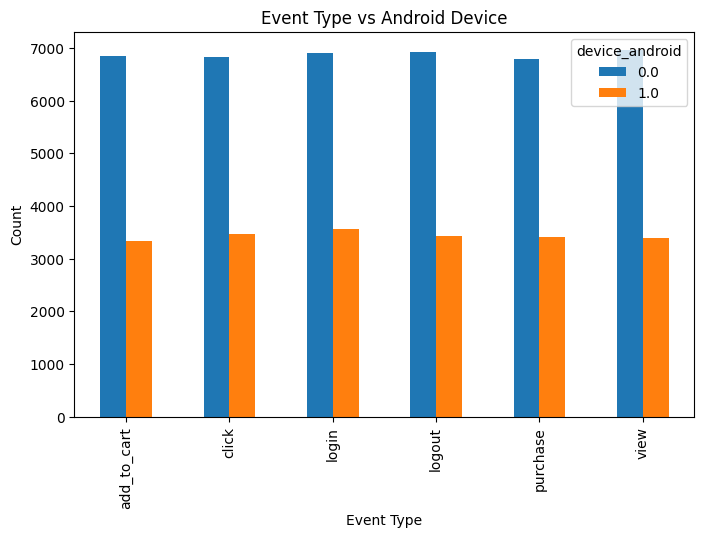

In [184]:
event_device = pd.crosstab(df['event_type'], df['device_android'])
event_device.plot(kind='bar', figsize=(8,5))
plt.title('Event Type vs Android Device')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

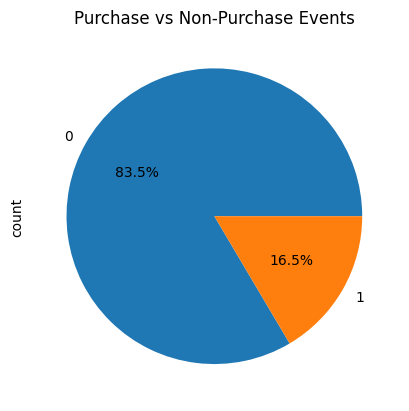

In [154]:
df['is_purchase'] = (df['event_type'] == 'purchase').astype(int)
df['is_purchase'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Purchase vs Non-Purchase Events')
plt.show()

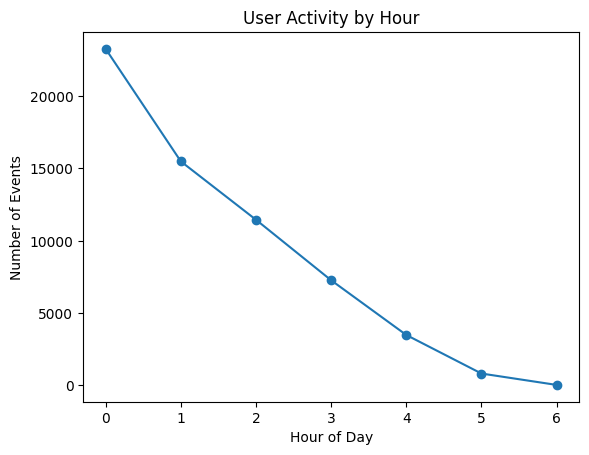

In [185]:
df.groupby('hour').size().plot(kind='line', marker='o')
plt.title('User Activity by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Events')
plt.show()

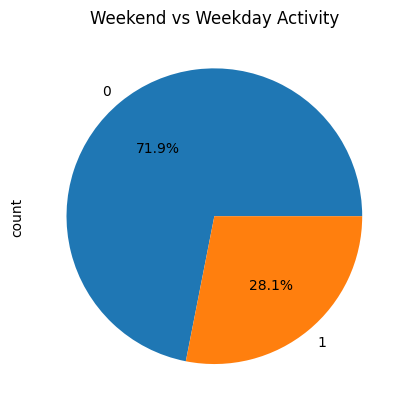

In [186]:
df['is_weekend'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Weekend vs Weekday Activity')
plt.show()


In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61837 entries, 0 to 61836
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      61837 non-null  int64         
 1   event_type   61837 non-null  object        
 2   timestamp    61837 non-null  datetime64[ns]
 3   session_id   61837 non-null  object        
 4   device       61837 non-null  object        
 5   country      61837 non-null  object        
 6   is_purchase  61837 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 3.3+ MB


In [158]:
df.sample(10)

,user_id,event_type,timestamp,session_id,device,country,is_purchase
46767,1491,purchase,2024-01-02 00:30:00,s_1491_1,android,UK,1
57065,1837,add_to_cart,2024-01-06 01:20:00,s_1837_2,desktop,Canada,0
59285,1908,purchase,2024-02-18 01:31:00,s_1908_4,desktop,India,1
23785,765,login,2024-01-17 01:37:00,s_765_5,android,Canada,0
37190,1169,add_to_cart,2024-02-19 03:08:00,s_1169_10,ios,UK,0
34033,1084,add_to_cart,2024-01-10 00:17:00,s_1084_1,ios,US,0
14468,489,logout,2024-02-17 02:03:00,s_489_4,ios,US,0
12469,417,click,2024-01-26 00:22:00,s_417_1,desktop,UK,0
41942,1324,add_to_cart,2024-02-17 00:39:00,s_1324_2,android,Canada,0
43562,1372,login,2024-02-01 02:41:00,s_1372_8,desktop,US,0


In [159]:
from sklearn.preprocessing import OneHotEncoder

In [160]:
oh = OneHotEncoder(sparse_output= False)
oh.fit(df[['country']])
trans_country = oh.transform(df[['country']])

In [161]:
trans_pd_country = pd.DataFrame(
    trans_country,
    columns=oh.get_feature_names_out(['country'])
)


In [162]:
trans_pd_country.sample(10)

,country_Canada,country_India,country_UK,country_US
22074,1.0,0.0,0.0,0.0
39452,1.0,0.0,0.0,0.0
59373,0.0,0.0,1.0,0.0
35849,0.0,1.0,0.0,0.0
21429,1.0,0.0,0.0,0.0
22335,0.0,0.0,1.0,0.0
49112,0.0,1.0,0.0,0.0
57477,0.0,0.0,1.0,0.0
28720,0.0,0.0,0.0,1.0
59321,0.0,0.0,1.0,0.0


In [163]:
df

,user_id,event_type,timestamp,session_id,device,country,is_purchase
0,1,purchase,2024-01-15 00:00:00,s_1_0,desktop,Canada,1
1,1,logout,2024-01-15 00:05:00,s_1_0,ios,Canada,0
2,1,view,2024-01-15 00:10:00,s_1_0,ios,US,0
3,1,login,2024-01-15 00:17:00,s_1_0,android,India,0
4,1,login,2024-01-15 00:19:00,s_1_1,android,India,0
...,...,...,...,...,...,...,...
61832,2000,click,2024-01-25 00:20:00,s_2000_0,android,India,0
61833,2000,add_to_cart,2024-01-25 00:21:00,s_2000_1,ios,US,0
61834,2000,view,2024-01-25 00:25:00,s_2000_1,desktop,Canada,0
61835,2000,login,2024-01-25 00:27:00,s_2000_1,desktop,US,0


In [164]:
df = df.drop('user_id',axis=1)

In [165]:
df = df.drop('country' , axis=1)

In [166]:
df = pd.concat([df,trans_pd_country] , axis= 1)

In [167]:
df

,event_type,timestamp,session_id,device,is_purchase,country_Canada,country_India,country_UK,country_US
0,purchase,2024-01-15 00:00:00,s_1_0,desktop,1,1.0,0.0,0.0,0.0
1,logout,2024-01-15 00:05:00,s_1_0,ios,0,1.0,0.0,0.0,0.0
2,view,2024-01-15 00:10:00,s_1_0,ios,0,0.0,0.0,0.0,1.0
3,login,2024-01-15 00:17:00,s_1_0,android,0,0.0,1.0,0.0,0.0
4,login,2024-01-15 00:19:00,s_1_1,android,0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
61832,click,2024-01-25 00:20:00,s_2000_0,android,0,0.0,1.0,0.0,0.0
61833,add_to_cart,2024-01-25 00:21:00,s_2000_1,ios,0,0.0,0.0,0.0,1.0
61834,view,2024-01-25 00:25:00,s_2000_1,desktop,0,1.0,0.0,0.0,0.0
61835,login,2024-01-25 00:27:00,s_2000_1,desktop,0,0.0,0.0,0.0,1.0


In [168]:
oh.fit(df[['device']])

,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'error'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [169]:
device_pd= pd.DataFrame(oh.transform(df[['device']]),columns = oh.get_feature_names_out(['device']))

In [170]:
df = df.drop('device',axis=1)
df=pd.concat([df,device_pd],axis=1)

In [171]:
df= df.drop('session_id',axis=1)

In [172]:
df

,event_type,timestamp,is_purchase,country_Canada,country_India,country_UK,country_US,device_android,device_desktop,device_ios
0,purchase,2024-01-15 00:00:00,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,logout,2024-01-15 00:05:00,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,view,2024-01-15 00:10:00,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,login,2024-01-15 00:17:00,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,login,2024-01-15 00:19:00,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
61832,click,2024-01-25 00:20:00,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
61833,add_to_cart,2024-01-25 00:21:00,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
61834,view,2024-01-25 00:25:00,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
61835,login,2024-01-25 00:27:00,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [173]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

df = df.drop('timestamp', axis=1)


In [174]:
df

,event_type,is_purchase,country_Canada,country_India,country_UK,country_US,device_android,device_desktop,device_ios,hour,day_of_week,is_weekend
0,purchase,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0
1,logout,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0
2,view,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,0
3,login,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0
4,login,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
61832,click,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,3,0
61833,add_to_cart,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,3,0
61834,view,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,3,0
61835,login,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,3,0


In [175]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
trans_event = pd.DataFrame(le.fit_transform(df['event_type']),columns = ['event_type'])

In [176]:
df['churn'] = (df['event_type'] != 'purchase').astype(int)
X = df.drop(['event_type', 'churn'], axis=1)
y = df['churn'].values.ravel()


In [177]:
df.sample(20)

,event_type,is_purchase,country_Canada,country_India,country_UK,country_US,device_android,device_desktop,device_ios,hour,day_of_week,is_weekend,churn
13993,purchase,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0
11716,logout,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3,6,1,1
43741,login,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,6,1,1
50442,add_to_cart,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,5,1,1
56402,purchase,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,4,0,0
41728,add_to_cart,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3,0,0,1
46132,purchase,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,1,0,0
59634,add_to_cart,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0,1
17794,purchase,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,2,0,0
11627,purchase,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0,0,0


In [178]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2, random_state = 42, stratify=y)

In [179]:
df['event_type'].isnull().sum()

np.int64(0)

In [180]:
df

,event_type,is_purchase,country_Canada,country_India,country_UK,country_US,device_android,device_desktop,device_ios,hour,day_of_week,is_weekend,churn
0,purchase,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0
1,logout,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,1
2,view,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,0,1
3,login,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0,1
4,login,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61832,click,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,3,0,1
61833,add_to_cart,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,3,0,1
61834,view,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,3,0,1
61835,login,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,3,0,1


In [181]:
df.sample(5)

,event_type,is_purchase,country_Canada,country_India,country_UK,country_US,device_android,device_desktop,device_ios,hour,day_of_week,is_weekend,churn
44340,login,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,6,1,1
45045,click,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,3,0,1
7554,logout,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,4,0,1
10688,add_to_cart,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,5,1,1
22095,logout,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2,0,0,1


In [182]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=800,
    max_depth=20,
    min_samples_leaf=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)


rf.fit(X_train, y_train)


,n_estimators,800
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [183]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2040
           1       1.00      1.00      1.00     10328

    accuracy                           1.00     12368
   macro avg       1.00      1.00      1.00     12368
weighted avg       1.00      1.00      1.00     12368



array([[ 2040,     0],
       [    0, 10328]])